Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [2]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black
import matplotlib.pyplot as plt

jupyter_black.load()

## Context
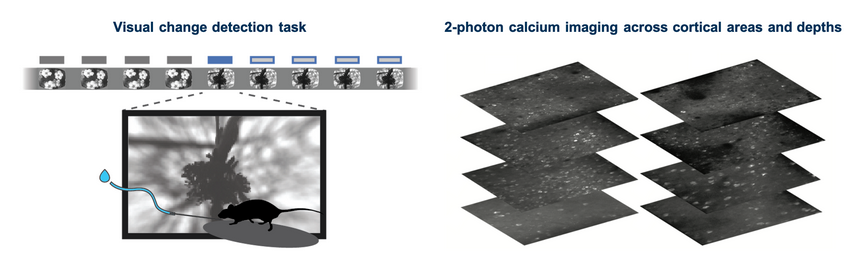

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

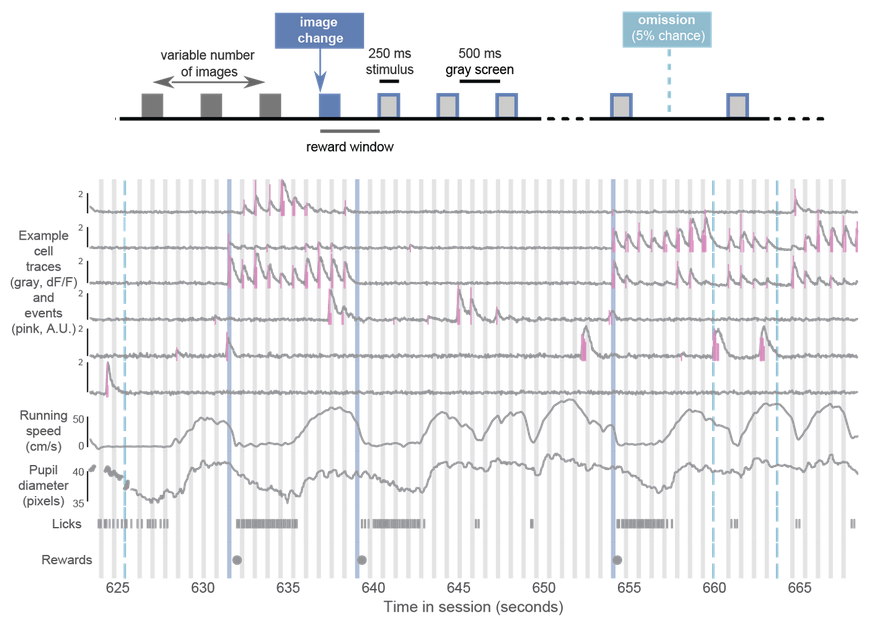

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [4]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

### Looking at the Data

firs, we look at the original documentation, to learn more about procedure and experimental set up of the experiment. through reverse image search of the attached pictures, we find that the data comes from allensswdb, and the documentation: https://allenswdb.github.io/physiology/ophys/visual-coding/vc2p-background.html

In [5]:
print_info(data)
print(data["stim_epoch_table"])
# filter for only the localy sparse stimulus data:
## side-note, first we have to rename the columns from the stim-epoch table, just to be tidy
data["stim_epoch_table"] = data["stim_epoch_table"].rename(
    columns={"start": "stimulus", "end": "start", "stimulus": "end"}
)
print(data["stim_epoch_table"])
# it is important to only do this (run the cell) once, since it changes the data directly.

[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)

                  start    end stimulus
0  locally_sparse_noise    737    22461
1           spontaneous  22611    31520
2     natural_movie_one  31521    40571
3  locally_sparse_noise  41476    63199
4     natural_movie_two  64105    73156
5           spontaneous  73306    82207
6  locally_sparse_noise  82208   105742
               stimulus  start     end
0  locally_sparse_noise    737   22461
1           spontaneous  22611   31520
2     natural_movie_one  31521   40571
3  locally_sparse_noise  41476   63199
4     natural_movie_two  64105   73

      frame  start    end
0         0    737    744
1         1    745    752
2         2    752    759
3         3    760    767
4         4    767    774
...     ...    ...    ...
2875   2875  22423  22430
2876   2876  22431  22438
2877   2877  22438  22446
2878   2878  22446  22453
2879   2879  22454  22461

[2880 rows x 3 columns]
      frame  start    end
2880   2880  41476  41483
2881   2881  41484  41491
2882   2882  41492  41499
2883   2883  41499  41506
2884   2884  41507  41514
...     ...    ...    ...
5755   5755  63162  63169
5756   5756  63170  63177
5757   5757  63177  63184
5758   5758  63185  63192
5759   5759  63192  63199

[2880 rows x 3 columns]
      frame   start     end
5760   5760   82208   82215
5761   5761   82215   82222
5762   5762   82223   82230
5763   5763   82230   82237
5764   5764   82238   82245
...     ...     ...     ...
8875   8875  105705  105712
8876   8876  105712  105719
8877   8877  105720  105727
8878   8878  105727  105734
8879   8879  10573

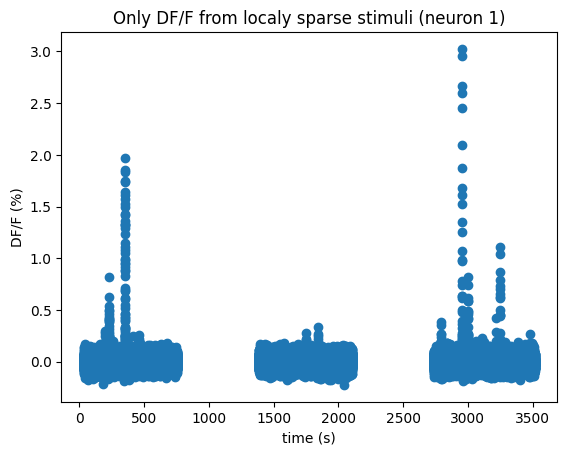

In [6]:
# now we can filter for the localy sparse stimulus:
# first get the correct stimuli, and extract their start- and end-times
times = data["stim_epoch_table"][
    data["stim_epoch_table"]["stimulus"] == "locally_sparse_noise"
][["start", "end"]].reset_index(drop=True)

# now get the data out of the df, put into smaller dfs, then concatenate those again.
new_data_accumulator_dfs = []
for idx, time in times.iterrows():
    start = time["start"]
    end = time["end"]

    new_data_accumulator_dfs.append(
        {
            "t": data["t"][start:end],
            "dff": data["dff"][:, start:end],
            "running_speed": data["running_speed"][:, start:end],
            "stim_table": data["stim_table"].loc[
                (data["stim_table"]["start"] >= start)
                & (data["stim_table"]["end"] <= end)
            ],
        }
    )
    print(new_data_accumulator_dfs[-1]["stim_table"])

new_data_accumulator_dfs
new_data_dict_df = data.copy()
new_data_dict_df["t"] = np.concatenate([acc["t"] for acc in new_data_accumulator_dfs])
new_data_dict_df["dff"] = np.concatenate(
    [acc["dff"] for acc in new_data_accumulator_dfs], axis=-1
)
new_data_dict_df["running_speed"] = np.concatenate(
    [acc["running_speed"] for acc in new_data_accumulator_dfs], axis=-1
)
new_data_dict_df["stim_table"] = pd.concat(
    [acc["stim_table"] for acc in new_data_accumulator_dfs]
)


# plot example spiketrain, for sanity check (scatter plot to have the sections not connected)
plt.scatter(new_data_dict_df["t"], new_data_dict_df["dff"][0])
plt.ylabel("DF/F (%)")
plt.xlabel("time (s)")
plt.title("Only DF/F from localy sparse stimuli (neuron 1)")
plt.show()

#### Short explanation of the data and the importance for the question.

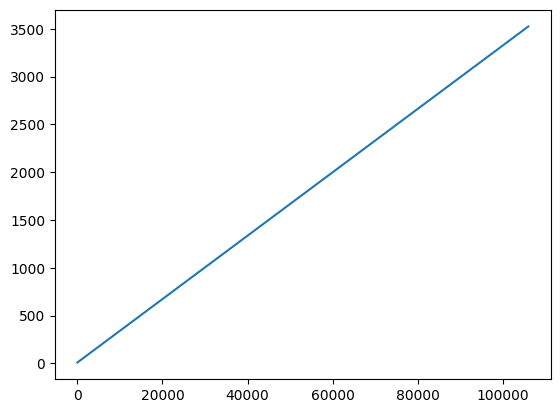

max value: 3524.5851
min value: 9.33015
differences between timepoints (sampling frequency): [0.03317 0.03318]


In [9]:
plt.plot(data["t"])
plt.show()
print("max value:", data["t"].max())
print("min value:", data["t"].min())
print(
    "differences between timepoints (sampling frequency):",
    np.unique(np.round((np.diff(data["t"])), 5)),
)

T seems to be the timestamp, in seconds.


In [36]:
new_data_dict_df["stim_table"]

,frame,start,end
0,0,737,744
1,1,745,752
2,2,752,759
3,3,760,767
4,4,767,774
...,...,...,...
8875,8875,105705,105712
8876,8876,105712,105719
8877,8877,105720,105727
8878,8878,105727,105734


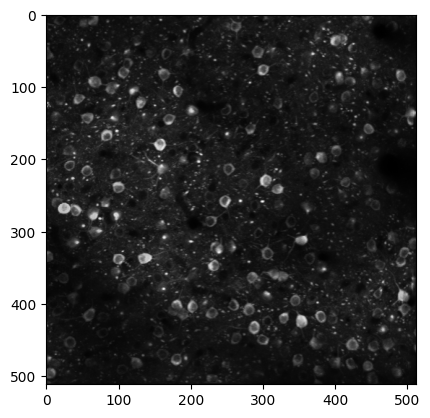

In [10]:
plt.imshow(data["max_projection"], cmap="grey")
plt.show()

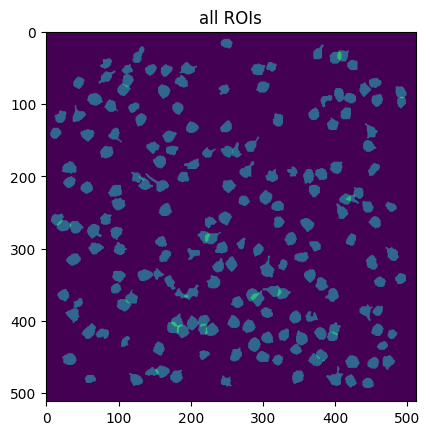

In [29]:
picture = np.zeros((512, 512))

for roi in new_data_dict_df["roi_masks"]:
    picture += roi

plt.imshow(picture)
plt.title("all ROIs")
plt.show()